# Overview
A phylogeny of FsxAs is inferred, and ecological metadata (manually obtained from data sources and/or from personal communications with authors of related papers) is plotted along with it.

# Data wrangling
Performing data wrangling in order to adjust labels (and similar cleaning operations aiming to get tidy data) in order to plot.

In [75]:
# adjusting size of plots shown in this Jupyter notebook
library(repr) # tip from here https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
options(repr.plot.width=20, repr.plot.height=20)

In [76]:
# running at OEG's scoville server, under conda environment <r_env_4>
# loading libraries
library(tidyverse)
library(glue)
library(magrittr)
library(ggtree)
library(readxl)

In [77]:
# loading tree data (all the files)
FsxA_kosher_linsi.tree = treeio::read.tree('../data/tree/NewSelEcoTree_iq2.contree')

In [78]:
# modifying tip label to be compatible with code
FsxA_kosher_linsi.tree$tip.label %<>% 
                            str_split('/') %>% 
                            purrr::map_chr(1) %>% 
                            str_replace_all(., 'mc35926358\\|Representative_scaffold16196_4', 'mc35926358|Representative_scaffold16196_4/1624') %>%
                            str_replace_all(., 'mc1330463358\\|Representative_gi\\|984778642\\|gb\\|LFUF01005182.1\\|_1', 
                                               'mc1330463358|Representative_gi|984778642|gb|LFUF01005182.1|_1/1417') %>%
                            str_replace_all(., 'mc1328965482\\|Representative_gi\\|998585003\\|gb\\|LFCJ01001378.1\\|_8', 
                                               'mc1328965482|Representative_gi|998585003|gb|LFCJ01001378.1|_8/1661') 

In [79]:
# rooting to get clade of HAP2s as outgroups
FsxA_kosher_linsi.tree2 = ape::root(FsxA_kosher_linsi.tree, outgroup = c('HAP2_Chlamy', '001179505.1', '000189635.1', '003719155.1', '000190715.1', '000313135.1'), resolve.root = TRUE)
FsxA_kosher_linsi.tree = FsxA_kosher_linsi.tree2

# minor trick to get root visible: setting length of the edge of the root (by default in zero) to the value of the first edge (leading to study group)
FsxA_kosher_linsi.tree$edge.length[FsxA_kosher_linsi.tree$edge.length == 0] = FsxA_kosher_linsi.tree$edge.length[1]

# load ecological categorical data
## define column names
ecological_data_columns = c('Sequence ID', 'Label in tree from fig. S17 B', 'scaffold ID - ORF',
                            'BIOSAMPLE', 'SAMPLE TYPE', 'MEDIA', 'SALINITY',
                            'pH', 'Temperature', 'O2', 'LOCATION')

ecological_data.tibble = readr::read_tsv('../data/metadata/Source_Data_Table1_complete_set_of_Fsx1s.tsv',
                                           col_names = ecological_data_columns, 
                                           skip = 1)

# performiing a little change in a too-long-tip
ecological_data.tibble %<>% dplyr::mutate(`Sequence ID` = `Sequence ID` %>% str_replace_all(., ' \\(new.*\\)', '')) 

Rows: 96 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): Sequence ID, Label in tree from fig. S17 B, scaffold ID - ORF, BIO...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [80]:
ecological_data_mio.tibble = readr::read_tsv('../data/metadata/Source_Data_Table1_complete_set_of_Fsx1s_mio.tsv',
                                             skip = 1)

Rows: 96 Columns: 18
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): Sequence ID, Label in tree from fig. S17 B, Complete amino acid se...
dbl  (4): Total AA length, Predicted TM domains (TOPCONS), Ectodomain length...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [81]:
ecological_data.tibble %<>% 
    dplyr::mutate(`Habitat` = case_when(LOCATION == 'Aerobic enrichment media from sediment sample' ~ 'Sediment sample',
                                        LOCATION == 'landfill leachate' ~ 'Landfill leachate',
                                        LOCATION == 'Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada' ~ 'Groundwater',
                                        LOCATION == 'Permafrost microbial communities from Stordalen Mire, Sweden' ~ 'Permafrost',
                                        LOCATION == 'Groundwater, Aspo Hard Rock Laboratory (HRL) deep subsurface site, Sweden' ~ 'Groundwater',
                                        LOCATION == 'Peatland  at the Marcell Experimental Forest in Minnesota' ~ 'Peatland',
                                        LOCATION == 'Saline lake microbial communities from Ace Lake, Antarctica' ~ 'Saline lake',
                                        LOCATION == 'hypersaline soda lake brines (LakeBitter-1(B1))' ~ 'Hypersaline soda lake',
                                        LOCATION == 'water collected from the Namib Desert Hosabes playa' ~ 'Water sample',
                                        LOCATION == 'Hot spring thermophilic microbial communities from Obsidian Pool, Yellowstone National Park, USA' ~ 'Hot spring',
                                        LOCATION == 'Temperate Freshwater Wetland sediment, Old Woman Creek National Estuarine Research Reserve, Ohio' ~ 'Freshwater',
                                        LOCATION == 'Soil microbial communities from Rifle, Colorado' ~ 'Soil sample',
                                        LOCATION == 'The sample material (saline water (ENVO:00002010), including plankton (ENVO:xxxxxxxx)) was collected at a depth of 596-605 m, targeting a mesopelagic zone (ENVO:00000213) & marine oxygen minimum zone (ENVO:01000065) in the marine biome (ENVO:00000447). The sample was size-fractionated (0.1-0.22 micrometres), and stored at -20 degC for later detection of large DNA virus nucleic acid sequences by pyrosequencing methods, and for later metagenomics analysis.' ~ 'Marine sample',
                                        LOCATION == 'Environmental > Aquatic > Marine > Oil-contaminated sediment' ~ 'Marine sample',
                                        LOCATION == 'Environmental > Aquatic > Marine > subseafloor sediment' ~ 'Marine sample',
                                        LOCATION == 'Environmental > Aquatic > Freshwater > Sediment' ~ 'Freshwater',
                                        LOCATION == 'Environmental > Aquatic > Marine > Intertidal zone > Salt marsh' ~ 'Marine sample',
                                        LOCATION == 'salt mine, China: Yunnan' ~ 'Salt mine',
                                        LOCATION == 'salt lake (Ayakekum), Altun mountain' ~ 'Saline lake',
                                        LOCATION == 'mixture of water from the Dead Sea and the Red Sea; Israel, Sedom' ~ 'Marine sample',
                                        LOCATION == 'brine of Lake Bitter-1 , Russia: Kulunda steppe' ~ 'Lake',
                                        LOCATION == 'Rifle groundwater metagenome at time 1 / A; 0.2 micron filter' ~ 'Groundwater',
                                        LOCATION == 'marine hydrothermal sediment' ~ 'Hydrothermal sample',
                                        LOCATION == 'marine hydrothermal sediment-HyVt-139' ~ 'Hydrothermal sample',
                                        LOCATION == 'Great Boiling Spring, Nevada' ~ 'Hot spring',
                                        LOCATION == 'Xinjiang salt lake sediment.' ~ 'Saline lake',
                                        LOCATION == 'Xinjiang saline soil sample' ~ 'Soil sample',
                                        LOCATION == 'Bioreactor' ~ 'Bioreactor',
                                        LOCATION == 'Pacific Ocean: East Pacific Rise, deepsea hydrothermal sulfide chimney' ~ 'Hydrothermal sample',
                                        LOCATION == 'Yellowstone National Park, Thermal springs, mud, sediment' ~ 'Hot spring',
                                        LOCATION == 'Mid-Cayman Rise Vent Fluids, UWMA-0176' ~ 'Hydrothermal sample',
                                        LOCATION == 'Solar saltern, India' ~ 'Solar saltern',
                                        TRUE ~ `LOCATION`)
                 )

In [82]:
# saving table to debate with Martin and Hector
ecological_data.tibble %>%
    dplyr::select(`Sequence ID`, LOCATION, Habitat) %>%
    readr::write_tsv(., '../results/plots/FsxA_ecotree_samples_and_habitats.tsv')

In [83]:
# further filtering
ecological_data_to_plot.tibble = ecological_data.tibble %>%
                                    dplyr::filter(`Sequence ID` != 'ASSIGNED TAXON:') 

In [84]:
# making a dictionary to change leaves
seqid2label = ecological_data_to_plot.tibble$`Label in tree from fig. S17 B`
names(seqid2label) = ecological_data_to_plot.tibble$`Sequence ID`

In [85]:
# must perform a minor trick in order to edit labels were a space was present (they were trimmed by IQTree when inferring phylogeny)

# load original sequences and their names, then create a table that relates them to their trimmed names
library(bioseq)
fsxa_ectodomain_sequences = bioseq::read_fasta('../data/sequences/FsxA_ectodomains.faa', type = 'AA')

missing_leaves = ecological_data_to_plot.tibble %>%
    dplyr::filter(!`Sequence ID` %in% FsxA_kosher_linsi.tree$tip.label) %>%
    .$`Sequence ID` %>% unique()

missing_leaves_correlation.tibble = tibble(original_names = names(fsxa_ectodomain_sequences)) %>%
    dplyr::mutate(trimmed_name = original_names %>% str_split(' ') %>% purrr::map_chr(1)) %>%
    # subsetting to those leafs that are missing, in order to restablish them
    dplyr::filter(original_names %in% missing_leaves) %>%
    # also, for names containing '='
    dplyr::mutate(trimmed_name = trimmed_name %>% str_replace_all(., '=', '_')) %>%
    # getting rid of a too long segment from a sequence
    dplyr::mutate(original_names = original_names %>% str_replace_all(., '\\(new.*\\)', '')) 

In [86]:
# performing leaf renaming in order to restablish original sequence names (and solved the trimming of the names)
# creating dictionary
library(tidytidbits)

missing_leaves_dict = missing_leaves_correlation.tibble$original_names
names(missing_leaves_dict) = missing_leaves_correlation.tibble$trimmed_name

FsxA_kosher_linsi.tree$tip.label %<>% tidytidbits::lookup_chr(., dict = missing_leaves_dict, default = identity)

In [87]:
# filtering to keep taxons in tree and ordering them according to the phylogeny
ecological_data_to_plot.tibble %<>%
    dplyr::filter(`Sequence ID` %in% FsxA_kosher_linsi.tree$tip.label)

# completing for missing data with NAs
missing_taxa = FsxA_kosher_linsi.tree$tip.label[!FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$`Sequence ID`]
ecological_data_to_plot.tibble %<>%
    bind_rows(tibble(`Sequence ID` = missing_taxa))

# ordering data according to tree tip.label order
ecological_data_to_plot.tibble$`Sequence ID` %<>% as.factor()
ecological_data_to_plot.tibble$`Sequence ID` %<>% forcats::fct_relevel(., FsxA_kosher_linsi.tree$tip.label)

ecological_data_to_plot.tibble %<>% dplyr::arrange(`Sequence ID`)

Performing minor checks

In [88]:
# filtering to keep taxons in tree and ordering them according to the phylogeny
ecological_data_to_plot.tibble %<>%
    dplyr::filter(`Sequence ID` %in% FsxA_kosher_linsi.tree$tip.label)

# completing for missing data with NAs
missing_taxa = FsxA_kosher_linsi.tree$tip.label[!FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$`Sequence ID`]
ecological_data_to_plot.tibble %<>%
    bind_rows(tibble(`Sequence ID` = missing_taxa))

# ordering data according to tree tip.label order
ecological_data_to_plot.tibble$`Sequence ID` %<>% as.factor()
ecological_data_to_plot.tibble$`Sequence ID` %<>% forcats::fct_relevel(., FsxA_kosher_linsi.tree$tip.label)

ecological_data_to_plot.tibble %<>% dplyr::arrange(`Sequence ID`)

# repeating test to see if now all labels are present in both directions
FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$`Sequence ID` %>% table()
ecological_data_to_plot.tibble$`Sequence ID` %in% FsxA_kosher_linsi.tree$tip.label %>% table()

.
TRUE 
  88 

.
TRUE 
  88 

In [89]:
# final check to see that dimensions are coherent
nrow(ecological_data_to_plot.tibble) == length(FsxA_kosher_linsi.tree$tip.label)

[1] TRUE

In [90]:
library(naniar)

In [91]:
# adding column TAXA

In [92]:
ecological_data_columns = c('HEADER','scaffold ID_ORF','scaffold ID_ORF (SPADES)','CONFIDENCE','META/GENOMICS PROJECT ID',
                               'TAXA','scaffold length','COMPLETE SEQUENCE','LENGTH','SIGNAL PEPTIDE?','TMs','ECTODOMAIN',
                               'ECTO LENGTH','C','Num CYS','ECTO Isoelectric point','COMMENTS','BIOSAMPLE','MG NAME',
                               'HABITAT_Detailed','Temperature_Detailed','elev mts','collec DATE','HABITAT','AUTHORS',
                               'CONTACT','PAPER DOI','ISOLATION','SOLID','AQUEOUS','SALT?','pH','T_Classified',
                               'ALT_DEPT (mts)','FILTER FRACTION','O2')

taxa_data.tibble = readr::read_tsv('../data/metadata/ecological_metadata_FsxAs.tsv',
                                           col_names = ecological_data_columns, 
                                           skip = 1)

# performiing a little change in a too-long-tip
taxa_data.tibble %<>% dplyr::mutate(HEADER = HEADER %>% str_replace_all(., ' \\(new.*\\)', '')) 

Rows: 95 Columns: 36
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (22): HEADER, scaffold ID_ORF, scaffold ID_ORF (SPADES), CONFIDENCE, MET...
dbl (14): scaffold length, LENGTH, SIGNAL PEPTIDE?, TMs, ECTO LENGTH, Num CY...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [93]:
taxa_data.tibble %<>% dplyr::select(`HEADER`, `TAXA`) %>% dplyr::rename(`Sequence ID` = 'HEADER')

In [94]:
ecological_data_to_plot.tibble %<>% dplyr::left_join(x = ., y = taxa_data.tibble, 'Sequence ID')

In [95]:
# getting rid and fixing some TAXA labels
ecological_data_to_plot.tibble %<>% dplyr::mutate(TAXA = TAXA %>% str_replace_all(., '^\\?$', '')) %>% naniar::replace_with_na(replace = list(TAXA = ''))
# modifying a tip label that is too large
ecological_data_to_plot.tibble %<>% dplyr::mutate(`Sequence ID` = `Sequence ID` %>% str_replace_all(., '\\(new.*\\)', '')) 

In [96]:
# renaming tip.labels in order to include taxa in the name
new_tip_label.tibble = FsxA_kosher_linsi.tree$tip.label %>%
    tibble(tip_label = .) %>%
    dplyr::left_join(x = .,
                     y = (ecological_data_to_plot.tibble %>% dplyr::select(`Sequence ID`, TAXA)),
                     by = c('tip_label' = 'Sequence ID')) %>%
    dplyr::mutate(new_tip_label = case_when(!is.na(TAXA) ~ glue('{tip_label} ({TAXA})') %>% as.character(),
                                            is.na(TAXA) ~ tip_label)
                 ) 

In [97]:
FsxA_kosher_linsi.tree$tip.label %<>%
    tibble(tip_label = .) %>%
    dplyr::left_join(x = .,
                     y = new_tip_label.tibble, 
                     by = 'tip_label') %>%
    .$new_tip_label

### Note regarding key system for each column
Columns of metadata were classified by Dr. Pablo Aguilar and coded in the following way (as can be seen in the original XLSX, send by email communication)

**Keys**
- $O_2$ :
    1. 1 = Aerobic
    2. 2 = Microaerophilic
    3. 3 = Anaerobic
    
- $T^o$ :
    1. 1 = Cryophilic (Up to 15 Celsius)
    2. 2 = Mesophilic (16-40 Celsius)
    3. 3 - Thermophilic (More than 41 Celsius)

- SALT? -> Should create color code only to mark that organism is hypersaline
    1. Hypersaline: 1 = Yes
    2. Hypersaline: 2 = No
- Aqueous: -> should create color code only to show that sample is aqueous
    1. 1 = Yes
    2. 2 = No
- Solid: -> should create color code only to show that sample is solid
    1. 1 = Yes
    2. 2 = No
    
- pH:
    1. 1 = < 6.5
    2. 2 = 6.6 - 7.5
    3. 3 = > 7.6


Modifying table in order to obtain meaningful tags for each metadata

In [98]:
library(naniar)
ecological_data_to_plot.tibble %<>%
    dplyr::left_join(x = .,
                     y = new_tip_label.tibble,
                     by = c('Sequence ID' = 'tip_label', 'TAXA' = 'TAXA')) %>%
    dplyr::mutate(., O2 = case_when(O2 == 'aerobic' ~ 'Aerobic', O2 == 'microaerophilic' ~ 'Microaerophilic', O2 == 'anaerobic' ~ 'Anaerobic'),
                     T_Classified = case_when(`Temperature` == 'cryophilic' ~ 'Cryophilic', `Temperature` == 'mesophilic' ~ 'Mesophilic', `Temperature` == 'thermophilic' ~ 'Termophilic'),
                     pH = case_when(pH == 'acidic' ~ '< 6.5', pH == 'neutral' ~ '6.6 - 7.5', pH == 'alkaline' ~ '> 7.6'),
                     `SALT?` = case_when(`SALINITY` == 'hypersaline' ~ 'Extreme hypersaline (> 150 g/lt)', 
                                         `SALINITY` == 'saline' ~ 'Moderate saline (30-150g/lt)', 
                                         `SALINITY` == 'freshwater' ~ 'Freshwater (< 1g/lt)'),
                     `Sample type` = case_when(MEDIA == 'liquid' ~ 'Aqueous', MEDIA == 'solid' ~ 'Solid'))


Annotating META/GENOMICS PROJECT ID and Habitat as letters in the branches

In [99]:
# creating dictionary
number_of_metagenome_projects = ecological_data_to_plot.tibble %>% dplyr::filter(!is.na(`BIOSAMPLE`)) %>% .$`BIOSAMPLE` %>% unique() %>% length()
tags_metagenome_projects = glue('MP {1:number_of_metagenome_projects}')
metagenome_projects.dict = tags_metagenome_projects 
names(metagenome_projects.dict) = ecological_data_to_plot.tibble %>% dplyr::filter(!is.na(`BIOSAMPLE`)) %>% .$`BIOSAMPLE` %>% unique()

In [100]:
# creating aliases for Metagenome Project IDs
# save this correlation table
ecological_data_to_plot.tibble %>% 
                    dplyr::select(new_tip_label, `BIOSAMPLE`) %>%
                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                    dplyr::arrange(`Metagenome Project ID`) %>%
                    readr::write_tsv('../results/metagenome_project_ID_tips_and_biosample_corr_table.tsv')

# Plotting

In [101]:
# creating heatmaps with metadata
library(ggplot2)
library(ggnewscale)

In [102]:
ecological_data_to_plot.tibble %>% names()

[1] "Sequence ID"                   "Label in tree from fig. S17 B"
 [3] "scaffold ID - ORF"             "BIOSAMPLE"                    
 [5] "SAMPLE TYPE"                   "MEDIA"                        
 [7] "SALINITY"                      "pH"                           
 [9] "Temperature"                   "O2"                           
[11] "LOCATION"                      "Habitat"                      
[13] "TAXA"                          "new_tip_label"                
[15] "T_Classified"                  "SALT?"                        
[17] "Sample type"

In [103]:
# creating specific datafrmes for each ecological variable to plot
df_habitat = ecological_data_to_plot.tibble %>% 
            dplyr::select(`new_tip_label`, `Habitat`) %>% 
            dplyr::filter(!is.na(`new_tip_label`)) %>%
            dplyr::mutate(`Habitat` = `Habitat` %>% as.factor()) %>%
            column_to_rownames('new_tip_label')

df_salt = ecological_data_to_plot.tibble %>% 
            dplyr::select(`new_tip_label`, `SALT?`) %>% 
            dplyr::filter(!is.na(`new_tip_label`)) %>%
            dplyr::mutate(`SALT?` = `SALT?` %>% as.factor() %>% forcats::fct_relevel(., c('Freshwater (< 1g/lt)', 'Moderate saline (30-150g/lt)', 'Extreme hypersaline (> 150 g/lt)'))) %>%
            dplyr::rename(Salinity = 'SALT?') %>% column_to_rownames('new_tip_label')

df_o2 = ecological_data_to_plot.tibble %>% 
            dplyr::select(`new_tip_label`, `O2`) %>% 
            dplyr::filter(!is.na(`new_tip_label`)) %>%
            dplyr::mutate(O2 = O2 %>% as.factor() %>% forcats::fct_relevel(., c('Anaerobic', 'Microaerophilic', 'Aerobic'))) %>%
            column_to_rownames('new_tip_label')


df_sampletype = ecological_data_to_plot.tibble %>% 
                    dplyr::select(`new_tip_label`, `Sample type`) %>% 
                    dplyr::filter(!is.na(`new_tip_label`)) %>%
                    dplyr::mutate(`Sample type` = `Sample type` %>% as.factor() %>% forcats::fct_relevel(., c('Solid', 'Aqueous'))) %>%
                    column_to_rownames('new_tip_label') 

df_pH = ecological_data_to_plot.tibble %>% 
            dplyr::select(`new_tip_label`, `pH`) %>% 
            dplyr::filter(!is.na(`new_tip_label`)) %>%
            dplyr::mutate(pH = pH %>% as.factor() %>% forcats::fct_recode(., `< 6.5` = '1', `6.6 - 7.5` = '2', `> 7.6` = '3')) %>%
            column_to_rownames('new_tip_label') 

df_temperature = ecological_data_to_plot.tibble %>% 
                    dplyr::select(`new_tip_label`, `T_Classified`) %>% 
                    dplyr::filter(!is.na(`new_tip_label`)) %>%
                    dplyr::mutate(`T_Classified` = `T_Classified` %>% as.factor() %>% forcats::fct_relevel(., c('Cryophilic', 'Mesophilic', 'Termophilic'))) %>%
                    dplyr::rename(Temperature = 'T_Classified') %>% 
                    column_to_rownames('new_tip_label') 

Warning message:
“Unknown levels in `f`: Microaerophilic”
Warning message:
“Unknown levels in `f`: 1, 2, 3”


Loading geographical relevant data to incoporate. 

___
**Note**: this part of the code isn't relevant to reproduce the final plot. It was part of exploratory analyses (not shown). The file *geodata_table.tsv* is the result of another notebook (basically retrieving data from NCBI BioSample databases) that is not shown, as it was part of previous exploratory analyses that were finally not employed.

___

In [104]:
geodata.tibble = readr::read_tsv('../results/geodata_table.tsv', col_names = TRUE)

Rows: 182 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): BioSample ID, Geographical location, Latitude, Longitude, Isolation...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [105]:
head(geodata.tibble)

BioSample ID,Geographical location,Latitude,Longitude,Isolation source,Title,Taxa ID,Organism
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SAMN06268799,"USA:Emeryville, CA",37.840854 N,122.289843 W,"Eden Landing Ponds, San Francisco, CA, USA","Aerobic enrichment media from Eden Landing Ponds, California, USA - A23 E1",655179,air metagenome
SAMN07630777,Canada: Ontario,43.4420 N,80.5770 W,composite cistern,"Leachate microbial communities from a municipal landfill in Southern Ontario, Canada - Pumphouse #3 metaG",1817679,landfill metagenome
SAMN07630779,Canada: Ontario,43.4420 N,80.5770 W,aquifer,"Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada - Groundwater well OW334 metaG",717931,groundwater metagenome
SAMN07630779,Canada: Ontario,43.4420 N,80.5770 W,aquifer,"Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada - Groundwater well OW334 metaG",717931,groundwater metagenome
SAMN07631793,Sweden: Stordalen,68.3500 N,19.0500 E,Mire fen,"Permafrost microbial communities from Stordalen Mire, Sweden - 712E3D metaG",1082480,permafrost metagenome
SAMN07630784,Sweden: Oskarshamn,57.4344 N,16.6600 E,Aspo Hard Rock Laboratory (HRL) deep subsurface site,"Groundwater microbial communities from the Aspo Hard Rock Laboratory (HRL) deep subsurface site, Sweden - MM_PW_MetaG",717931,groundwater metagenome


In [106]:
# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    
ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(new_tip_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')

d2 %<>% 
    dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
    dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
                                     TRUE ~ newlab)) %>%
    as.data.frame()


d3 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label) %>% dplyr::mutate(newlab = 1:nrow(.)) %>% as.data.frame()

# save d3
d3 %>% readr::write_tsv(., '../results/seqid2simple_code_ecotree.tsv', col_names = TRUE)

# replacing bootstrap values to fixed values in order to group values between 50 -74 (under value 35), 75-89 (value 75), and >= 90 (values 90) 
# (values below 50 anotated as NA)
FsxA_kosher_linsi.tree$node.label = c('Root','"', 90, 90, 90, 35, 90, 35, 90, 75,
                                      90, 35, NA, 90, 75, 90, 90, 90, 90, 
                                      90, 90, NA, 35, 35, 90, 75, 75, 90, 75, 
                                      90, 90, 75, 75, 75, 90, 90, 90, 90, 90, 
                                      90, 35, 75, 90, 90, 90, 75, 90, 75, 75, 
                                      90, 75, 35, 90, 90, 90, 90, 90, 90, 90, 
                                      75, 90, 90, 75, 90, 90, 35, 75, 75, 90, 
                                      90, 90, 35, 90, 75, 90, 75, 90, 90, 90, 90, 
                                      90, 90, 90, 90, 90, 90, 90)

treeplot_linsi = ggtree(FsxA_kosher_linsi.tree, layout = 'circular') + 
                    ggplot2::xlim(0, 6.5) 

# save tree
FsxA_kosher_linsi.tree %>% ape::write.tree('../results/Phylo-Eco-tree.newick')

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (1.35 + 1.77  + 0.07*2*0 -1.75), width=.030, colnames_position = 'top',
               colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



In [107]:
# first creating a data frame for that purpose
ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    
ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(new_tip_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')

d2 %<>% 
    dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
    dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
                                     TRUE ~ newlab)) %>%
    as.data.frame()


d3 = ecological_data_to_plot.tibble %>% dplyr::select(`new_tip_label`, `Label in tree from fig. S17 B`) %>%
     dplyr::rename(`Label in tree` = 'Label in tree from fig. S17 B')   %>% as.data.frame()

# save d3
d3 %>% readr::write_tsv(., '../results/seqid2simple_code_ecotree.tsv', col_names = TRUE)

FsxA_kosher_linsi.tree$node.label = c('Root','"', 90, 90, 90, 35, 90, 35, 90, 75,
                                      90, 35, NA, 90, 75, 90, 90, 90, 90, 
                                      90, 90, NA, 35, 35, 90, 75, 75, 90, 75, 
                                      90, 90, 75, 75, 75, 90, 90, 90, 90, 90, 
                                      90, 35, 75, 90, 90, 90, 75, 90, 75, 75, 
                                      90, 75, 35, 90, 90, 90, 90, 90, 90, 90, 
                                      75, 90, 90, 75, 90, 90, 35, 75, 75, 90, 
                                      90, 90, 35, 90, 75, 90, 75, 90, 90, 90, 90, 
                                      90, 90, 90, 90, 90, 90, 90)

treeplot_linsi = ggtree(FsxA_kosher_linsi.tree, layout = 'circular') + 
                    ggplot2::xlim(0, 6.5) 

# save tree
FsxA_kosher_linsi.tree %>% ape::write.tree('../results/Phylo-Eco-tree.newick')

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (1.35 + 1.77  + 0.07*2*0 -1.75), width=.030, colnames_position = 'top',
               colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'),
                      na.value = 'white')

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(1.35 + 1.77  + 0.07*2*1 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 0.25 - 0.45) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7'), na.value = 'white') +  
         theme(legend.position="bottom")


p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(1.35 + 1.77  + 0.07*2*2 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 + 0.45) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81"), na.value = 'white') +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(1.35 + 1.77  + 0.07*2*3 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 - 0.4) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5'), na.value = 'white') +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(1.35 + 1.77  + 0.07*2*4 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 + 0.4) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400'), na.value = 'white') +  
         theme(legend.position="right")

#d3 %<>%
#    dplyr::mutate(`Assembly source` = case_when(newlab %in% c(50, 51, 78, 79, 80, 81, 85, 86) ~ 'PCG archaea',
#                                       TRUE ~ 'MAG/assembled metagenome'))

#metadata_fsxA = readr::read_tsv('../data/metadata/source_data_table_1_fsxa.tsv')
#metadata_replace = metadata_fsxA %>% dplyr::select(`Extended Data Figure 8 FsxA #`, `Label in tree`)
#metadata_replace %<>% dplyr::filter(!is.na(`Label in tree`))
#d3 %<>% dplyr::left_join(x = ., y = metadata_replace, by = c('newlab' = 'Extended Data Figure 8 FsxA #'))
d3 %<>% dplyr::mutate(`Label in tree` = case_when(is.na(`Label in tree`) ~ `new_tip_label`, !is.na(`Label in tree`) ~ `Label in tree`))
d3 %<>%
    dplyr::mutate(`Assembly source` = case_when(`Label in tree` %in% c('Haloferax sp.', 'H. natans', 
                                                                       'Haloterrigena sp.', 'Halovivax sp', 
                                                                       'N. altunense JCM 12890', 'N. altunense AJ2', 
                                                                       'Halobonum sp.', 'H. borinquense') ~ 'PCG archaea',
                                       TRUE ~ 'MAG/assembled metagenome'))
p5 = p5 %<+% d3 + 
                       geom_text2(aes(label=`Label in tree`, color = `Assembly source`, angle=angle), hjust=-.25, na.rm = T, vjust=0.5, size=5) +
                       theme(legend.position = 'right') +
                       scale_color_manual(values = c(`PCG archaea` = '#FC4E07',
                                                     `MAG/assembled metagenome`= '#000000'))

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



In [108]:
p6 = p5 + geom_nodepoint(aes(subset = !isTip, alpha = 0.35, size=as.numeric(label), colour = label)) + 
    scale_size(range = c(4,6)) + 
    scale_colour_manual(values=c(`PCG archaea` = '#FC4E07',
                                 `MAG/assembled metagenome`= '#000000', 
                                 "35" = "brown3", 
                                 "75" = "darkolivegreen4",
                                 "90" = "royalblue4"))

p6 %>% ggsave(filename = "../results/plots/Phylo-Eco-mapping_with_O2_bootstrap.pdf", 
                          plot = .,
                          width = 60, 
                          height = 60, 
                          units = 'cm',
                          limitsize = FALSE)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message:
“Removed 4 rows containing missing values (geom_point_g_gtree).”


Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message:
“Removed 4 rows containing missing values (geom_point_g_gtree).”


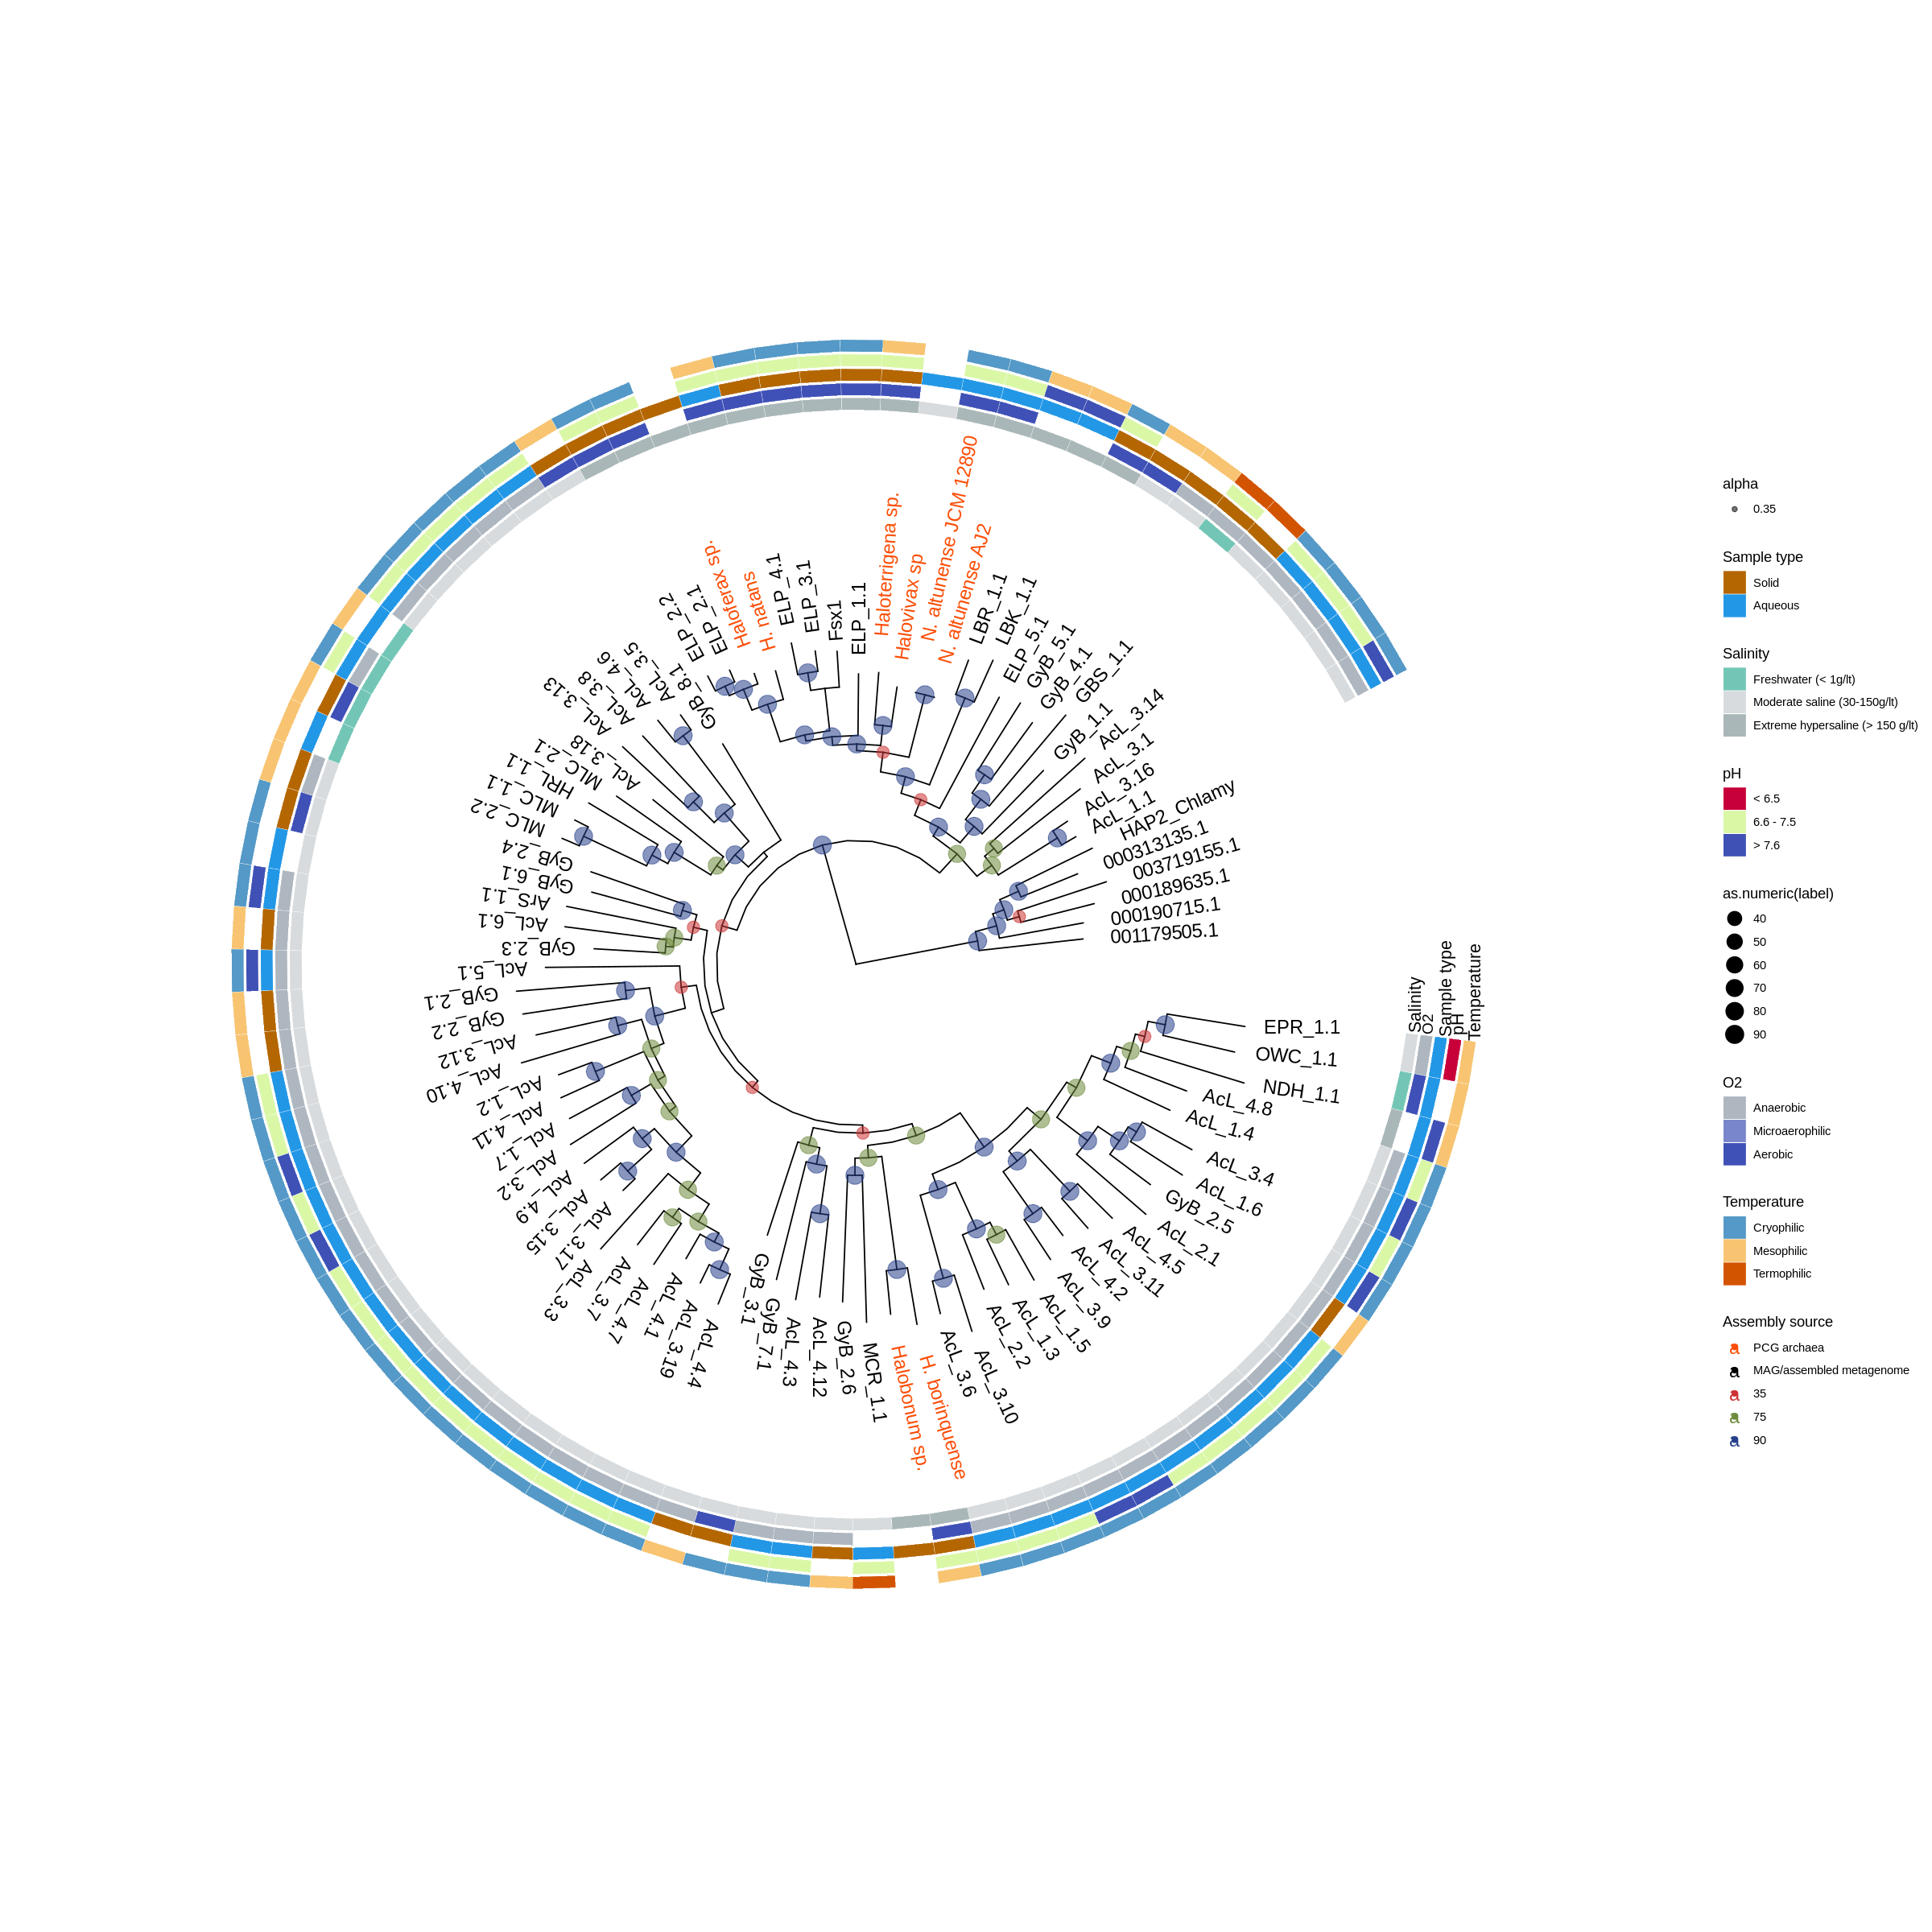

In [109]:
p6

**Note**: this is the base plot obtained in order to create the final plot shown in the main text, along with protein structural data. Manual aesthetical curation of it was performed by Dr. Martin Graña and Dr. Pablo Aguilar, employing standard image editors.

___

In [110]:
# saving label codes
d3 %>% as_tibble() %>% readr::write_tsv('../results/plots/sample_tip_codes.tsv', col_names = T)

In [111]:
# making dictionary in order to save tree as shown in the main text
tiplabel_dict = d3$`Label in tree`
names(tiplabel_dict) = d3$new_tip_label

In [112]:
# saving phylogenetic tree with simplified tips
FsxA_kosher_linsi.tree$tip.label %<>% tidytidbits::lookup_chr(., dict = tiplabel_dict)

In [113]:
FsxA_kosher_linsi.tree %>% ape::write.tree(., '../results/NewSelEcoTree_iq2_simple_ids.nwk')